In [ ]:
!pip install torch torchvision numpy matplotlib tqdm


In [4]:
# Federated Learning 실습용 라이브러리 임포트
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# 디바이스 설정: GPU가 있으면 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
# reproducibility를 위한 시드 설정
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)

In [6]:


# ─────────────── Step 2: 데이터셋 준비 & Dirichlet 비IID 분할 ───────────────

from torchvision.datasets import MNIST
from torch.utils.data import Subset

# 1) MNIST 학습 데이터 다운로드 및 전처리 정의
transform = transforms.Compose([
    transforms.ToTensor(),                           # Tensor로 변환
    transforms.Normalize((0.1307,), (0.3081,))       # 평균·표준편차 정규화
])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

# 2) Dirichlet 분포 기반 데이터 분할 함수
def partition_dirichlet(dataset, num_clients, alpha):
    """
    dataset: torchvision Dataset (targets 속성 사용)
    num_clients: 클라이언트 수
    alpha: Dirichlet 분포 파라미터
    return: {client_id: [데이터 인덱스 리스트]}
    """
    targets = np.array(dataset.targets)
    num_classes = len(np.unique(targets))
    class_indices = {c: np.where(targets == c)[0] for c in range(num_classes)}

    client_indices = {i: [] for i in range(num_clients)}

    for c, idxs in class_indices.items():
        np.random.shuffle(idxs)
        proportions = np.random.dirichlet([alpha] * num_clients)
        counts = (proportions * len(idxs)).astype(int)

        start = 0
        for client_id, count in enumerate(counts):
            client_indices[client_id].extend(idxs[start:start + count])
            start += count
        if start < len(idxs):
            client_indices[num_clients - 1].extend(idxs[start:])

    return client_indices

# 3) α 값 리스트 & 분할 실행
alphas = [0.1, 0.5, 1.0]
split_indices = {
    alpha: partition_dirichlet(train_dataset, num_clients=3, alpha=alpha)
    for alpha in alphas
}

# 4) 분할 결과 확인 출력
for alpha in alphas:
    print(f"➤ Alpha = {alpha}")
    for client_id in range(3):
        cnt = len(split_indices[alpha][client_id])
        print(f"   - Client {client_id}: {cnt} samples")
    print()

➤ Alpha = 0.1
   - Client 0: 23772 samples
   - Client 1: 17087 samples
   - Client 2: 19141 samples

➤ Alpha = 0.5
   - Client 0: 26487 samples
   - Client 1: 12312 samples
   - Client 2: 21201 samples

➤ Alpha = 1.0
   - Client 0: 21691 samples
   - Client 1: 14420 samples
   - Client 2: 23889 samples



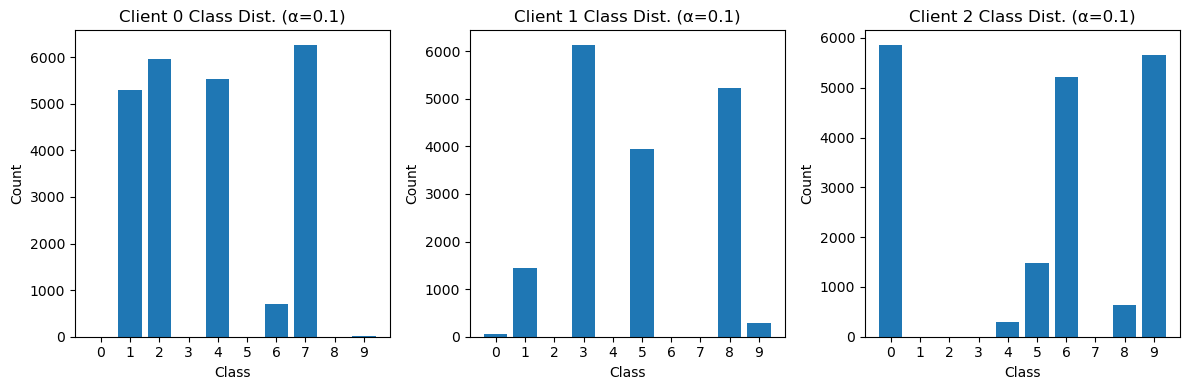

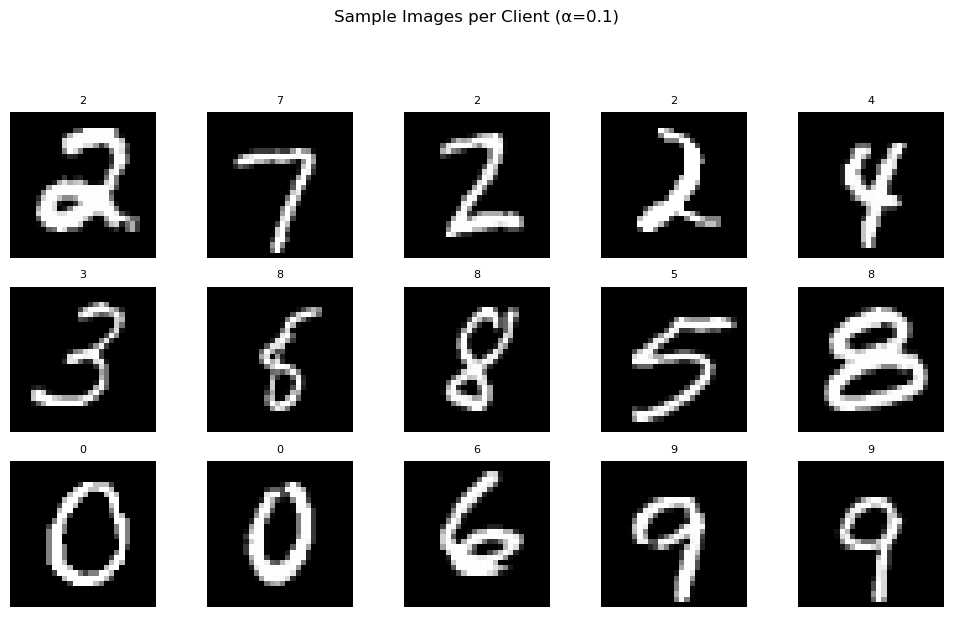

In [7]:
# ─────────────── Step 2-1: 클라이언트별 클래스 분포 & 샘플 이미지 시각화 ───────────────

import matplotlib.pyplot as plt
import numpy as np

def visualize_clients(dataset, split_idx, alpha, num_samples=5):
    """
    dataset: torchvision Dataset
    split_idx: partition_dirichlet 결과 {client_id: [indices]}
    alpha: Dirichlet α 값 (제목용)
    num_samples: 클라이언트당 보여줄 샘플 이미지 수
    """
    num_clients = len(split_idx)
    num_classes = len(np.unique(dataset.targets))

    # ── 1) 클래스 분포 히스토그램 ──
    fig, axes = plt.subplots(1, num_clients, figsize=(4 * num_clients, 4))
    for cid in range(num_clients):
        labels = np.array(dataset.targets)[split_idx[cid]]
        counts = np.bincount(labels, minlength=num_classes)
        ax = axes[cid] if num_clients > 1 else axes
        ax.bar(np.arange(num_classes), counts)
        ax.set_title(f'Client {cid} Class Dist. (α={alpha})')
        ax.set_xlabel('Class')
        ax.set_ylabel('Count')
        ax.set_xticks(np.arange(num_classes))
    plt.tight_layout()
    plt.show()

    # ── 2) 샘플 이미지 그리드 ──
    fig, axs = plt.subplots(num_clients, num_samples,
                             figsize=(2 * num_samples, 2 * num_clients))
    for cid in range(num_clients):
        chosen = np.random.choice(split_idx[cid], size=num_samples, replace=False)
        for i, idx in enumerate(chosen):
            img, label = dataset[idx]
            ax = axs[cid, i] if num_clients > 1 else axs[i]
            ax.imshow(img.squeeze(), cmap='gray')
            ax.set_title(f'{label}', fontsize=8)
            ax.axis('off')

    plt.suptitle(f'Sample Images per Client (α={alpha})', y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# 예시 호출 (α=0.1 분할에 대해)
visualize_clients(train_dataset, split_indices[0.1], alpha=0.1, num_samples=5)


In [8]:
# ─────────────── Step 3: 클라이언트별 DataLoader 정의 & 경량 CNN 모델 설계 ───────────────

from torch.utils.data import DataLoader, Subset
import torch.nn as nn

# 1) 클라이언트별 Subset & DataLoader 생성 함수
def make_client_loaders(dataset, split_idx, batch_size=32):
    """
    dataset: 전체 학습 Dataset (torchvision Dataset)
    split_idx: 클라이언트별 인덱스 딕셔너리, e.g. {0: [...], 1: [...], 2: [...]}
    batch_size: 배치 크기
    return: {client_id: DataLoader}
    """
    loaders = {}
    for cid, idxs in split_idx.items():
        # Subset으로 클라이언트 전용 데이터셋 생성
        subset = Subset(dataset, idxs)
        # DataLoader 생성 (셔플 포함)
        loader = DataLoader(
            subset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,       # 윈도우 환경에서 2로 설정 권장
            pin_memory=True      # GPU 사용 시 메모리 고정으로 속도 향상
        )
        loaders[cid] = loader
    return loaders

# 예시: 알파=0.1인 경우의 클라이언트별 DataLoader 딕셔너리
client_loaders_alpha01 = make_client_loaders(train_dataset, split_indices[0.1], batch_size=32)

# 2) 경량 CNN 모델 정의
class LightCNN(nn.Module):
    """
    MNIST 10-class 분류용 간단한 CNN
    - Conv2d → ReLU → MaxPool 반복 후
    - Fully-Connected → ReLU → Dropout → 출력
    """
    def __init__(self):
        super().__init__()
        # 첫 번째 합성곱 블록: 입력 채널 1 → 출력 채널 16
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        # 두 번째 합성곱 블록: 16 → 32
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # 풀링: 2x2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 드롭아웃: 과적합 방지
        self.dropout = nn.Dropout(p=0.25)
        # 완전연결층: feature map 크기 32×7×7 → 히든 128
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        # 출력층: 128 → 클래스 수 10
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # (B,1,28,28) → Conv1 → ReLU → Pool → (B,16,14,14)
        x = self.pool(F.relu(self.conv1(x)))
        # → Conv2 → ReLU → Pool → (B,32,7,7)
        x = self.pool(F.relu(self.conv2(x)))
        # 플래튼 → (B, 32*7*7)
        x = x.view(x.size(0), -1)
        # FC1 → ReLU → Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # FC2 → 로짓 반환
        x = self.fc2(x)
        return x

# 3) 모델 인스턴스 생성 및 디바이스 할당 예시
model = LightCNN().to(device)
print(model)


LightCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# ─────────────── Step 4: FedAvg 구현 및 단일 실험 실행 ───────────────

import copy
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# 1) 테스트 데이터 로더 준비
test_dataset = MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# 2) 테스트 함수 정의
def evaluate(model, loader):
    """
    모델의 정확도를 평가하는 유틸 함수
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            preds = outputs.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    return correct / total

# 3) FedAvg 하이퍼파라미터 설정
num_rounds = 5          # 통신 라운드 수
local_epochs = 1        # 클라이언트 로컬 학습 에포크
lr = 0.01               # 학습률
clients = client_loaders_alpha01  # 예시: alpha=0.1 분할을 사용하는 3개 클라이언트

# 4) 글로벌 모델 초기화 (LightCNN 사용)
global_model = LightCNN().to(device)

# 5) FedAvg 학습 루프
for round_idx in range(1, num_rounds + 1):
    print(f"--- Round {round_idx} ---")
    # 각 클라이언트에서 학습된 모델 파라미터 수집
    local_state_dicts = []

    for cid, loader in clients.items():
        # 5-1) 글로벌 모델 복사 → 로컬 모델 생성
        local_model = copy.deepcopy(global_model)
        optimizer = optim.SGD(local_model.parameters(), lr=lr)

        # 5-2) 로컬 학습
        local_model.train()
        for epoch in range(local_epochs):
            for data, target in loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                outputs = local_model(data)
                loss = F.cross_entropy(outputs, target)
                loss.backward()
                optimizer.step()

        # 5-3) 학습된 로컬 모델의 state_dict 저장
        local_state_dicts.append(local_model.state_dict())

    # 6) 모델 파라미터 연 평균 (FedAvg)
    new_global_dict = copy.deepcopy(global_model.state_dict())
    for key in new_global_dict.keys():
        # 클라이언트마다 동일한 키의 텐서를 평균
        stacked = torch.stack([sd[key].float() for sd in local_state_dicts], dim=0)
        new_global_dict[key] = stacked.mean(dim=0)
    # 7) 글로벌 모델 업데이트
    global_model.load_state_dict(new_global_dict)

    # 8) 글로벌 모델 평가
    acc = evaluate(global_model, test_loader)
    print(f"Global model test accuracy: {acc * 100:.2f}%\n")


In [ ]:
# ─────────────── Step 5-1: FedAvgM (FedAvg with Server Momentum) 구현 및 실행 ───────────────

import copy

# FedAvgM 하이퍼파라미터
num_rounds = 5            # 통신 라운드 수
local_epochs = 1          # 클라이언트 로컬 학습 에포크
lr = 0.01                 # 로컬 학습률 (SGD)
server_momentum = 0.9     # 서버 모멘텀 계수
clients = client_loaders_alpha01  # α=0.1 분할을 사용하는 클라이언트

# 글로벌 모델 초기화 & 이전 글로벌 파라미터 저장
global_model = LightCNN().to(device)
prev_global_dict = copy.deepcopy(global_model.state_dict())

# 서버 업데이트(모멘텀) 초기화: 이전 업데이트 값 저장용
server_update = {k: torch.zeros_like(v) for k, v in prev_global_dict.items()}

for round_idx in range(1, num_rounds + 1):
    print(f"--- FedAvgM Round {round_idx} ---")
    # 1) 각 클라이언트 로컬 학습 후 state_dict 수집 (동일)
    local_state_dicts = []
    for cid, loader in clients.items():
        local_model = copy.deepcopy(global_model)
        optimizer = optim.SGD(local_model.parameters(), lr=lr)
        local_model.train()
        for epoch in range(local_epochs):
            for data, target in loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                out = local_model(data)
                loss = F.cross_entropy(out, target)
                loss.backward()
                optimizer.step()
        local_state_dicts.append(local_model.state_dict())

    # 2) FedAvg로 새 글로벌 파라미터 계산
    new_global_dict = {}
    for key in prev_global_dict.keys():
        stacked = torch.stack([sd[key].float() for sd in local_state_dicts], dim=0)
        new_global_dict[key] = stacked.mean(dim=0)

    # 3) 서버 모멘텀 적용
    #    Δw = new_global - prev_global
    #    server_update = β * server_update + Δw
    #    updated_global = prev_global + server_update
    updated_global = {}
    for key in prev_global_dict.keys():
        delta = new_global_dict[key] - prev_global_dict[key]
        server_update[key] = server_momentum * server_update[key] + delta
        updated_global[key] = prev_global_dict[key] + server_update[key]

    # 4) 글로벌 모델에 파라미터 로드 및 prev_global 업데이트
    global_model.load_state_dict(updated_global)
    prev_global_dict = copy.deepcopy(global_model.state_dict())

    # 5) 테스트 데이터셋으로 평가
    acc = evaluate(global_model, test_loader)
    print(f"FedAvgM test accuracy: {acc * 100:.2f}%\n")


In [ ]:
# ─────────────── Step 5-2: FedProx 구현 및 실행 ───────────────

import copy

# FedProx 하이퍼파라미터
num_rounds   = 5        # 통신 라운드 수
local_epochs = 1        # 클라이언트 로컬 학습 에포크
lr           = 0.01     # 로컬 학습률 (SGD)
mu           = 0.1      # Proximal 항 계수
clients      = client_loaders_alpha01  # α=0.1 분할을 사용하는 클라이언트

# 글로벌 모델 초기화
global_model = LightCNN().to(device)

for round_idx in range(1, num_rounds + 1):
    print(f"--- FedProx Round {round_idx} ---")
    global_params = {k: v.clone().detach() for k, v in global_model.state_dict().items()}
    local_state_dicts = []

    # 1) 각 클라이언트 로컬 학습
    for cid, loader in clients.items():
        # 1-1) 글로벌 모델 복사 → 로컬 모델 생성
        local_model = copy.deepcopy(global_model)
        optimizer   = optim.SGD(local_model.parameters(), lr=lr)

        # 1-2) 로컬 학습 (FedProx: proximal term 추가)
        local_model.train()
        for epoch in range(local_epochs):
            for data, target in loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                outputs = local_model(data)
                loss    = F.cross_entropy(outputs, target)

                # proximal term: μ/2 * || w - w_global ||^2
                prox_term = 0.0
                for name, param in local_model.named_parameters():
                    prox_term += torch.norm(param - global_params[name])**2
                loss += (mu / 2) * prox_term

                loss.backward()
                optimizer.step()

        # 1-3) 학습된 로컬 모델 파라미터 저장
        local_state_dicts.append(local_model.state_dict())

    # 2) 서버에서 FedAvg 방식으로 파라미터 평균
    new_global_dict = {}
    for key in global_params.keys():
        stacked = torch.stack([sd[key].float() for sd in local_state_dicts], dim=0)
        new_global_dict[key] = stacked.mean(dim=0)

    # 3) 글로벌 모델 업데이트
    global_model.load_state_dict(new_global_dict)

    # 4) 글로벌 모델 평가
    acc = evaluate(global_model, test_loader)
    print(f"FedProx test accuracy: {acc * 100:.2f}%\n")


In [ ]:
# ─────────────── Step 5-3: SCAFFOLD 구현 및 실행 ───────────────

import copy

# SCAFFOLD 하이퍼파라미터
num_rounds   = 5          # 통신 라운드 수
local_epochs = 1          # 클라이언트 로컬 학습 에포크
lr           = 0.01       # 로컬 학습률 (SGD)
clients      = client_loaders_alpha01  # α=0.1 분할을 사용하는 클라이언트

# 1) 글로벌 모델 초기화
global_model = LightCNN().to(device)

# 2) 글로벌 파라미터 및 제어변수(c_global) 초기화 (CPU 상에 관리)
global_params = {k: v.clone().detach().cpu() for k, v in global_model.state_dict().items()}
c_global     = {k: torch.zeros_like(v) for k, v in global_params.items()}

# 3) 각 클라이언트 제어변수(c_i) 초기화
c_locals = {
    cid: {k: torch.zeros_like(v) for k, v in global_params.items()}
    for cid in clients.keys()
}

for round_idx in range(1, num_rounds + 1):
    print(f"--- SCAFFOLD Round {round_idx} ---")
    local_states = []    # 클라이언트별 학습 후 파라미터 저장
    new_c_locals = {}    # 클라이언트별 업데이트된 제어변수 저장

    # 4) 각 클라이언트 로컬 학습
    for cid, loader in clients.items():
        # 4-1) 글로벌 모델 복사 → 로컬 모델 생성
        local_model = copy.deepcopy(global_model)
        optimizer   = optim.SGD(local_model.parameters(), lr=lr)

        # 클라이언트 제어변수 가져오기
        c_i = c_locals[cid]

        # 4-2) 로컬 학습 (gradient 조정)
        local_model.train()
        for epoch in range(local_epochs):
            for data, target in loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                outputs = local_model(data)
                loss    = F.cross_entropy(outputs, target)
                loss.backward()

                # 각 파라미터 gradient에 제어변수 차이 반영: grad += c_global - c_i
                for name, param in local_model.named_parameters():
                    grad_correction = (c_global[name] - c_i[name]).to(device)
                    param.grad.data.add_(grad_correction)

                optimizer.step()

        # 4-3) 학습된 로컬 파라미터 및 제어변수 업데이트
        local_state = local_model.state_dict()
        local_states.append(local_state)

        # c_i^{new} = c_i - c_global + (w_global - w_i) / (lr * local_epochs)
        updated_c_i = {}
        for name in global_params.keys():
            w_global = global_params[name]
            w_local  = local_state[name].cpu()
            updated_c_i[name] = c_i[name] - c_global[name] + (w_global - w_local) / (lr * local_epochs)
        new_c_locals[cid] = updated_c_i

    # 5) 서버에서 글로벌 파라미터 평균 (FedAvg 방식)
    averaged_params = {}
    for name in global_params.keys():
        stacked = torch.stack([st[name].cpu().float() for st in local_states], dim=0)
        averaged_params[name] = stacked.mean(dim=0)

    # 6) c_global 업데이트: c_global += (1/K) * Σ (c_i^{new} - c_i)
    for cid in clients.keys():
        for name in c_global.keys():
            c_global[name] += (new_c_locals[cid][name] - c_locals[cid][name]) / len(clients)

    # 7) 글로벌 모델 & 파라미터·제어변수 동기화
    global_model.load_state_dict({k: averaged_params[k].to(device) for k in averaged_params})
    global_params = {k: v.clone().detach().cpu() for k, v in global_model.state_dict().items()}
    c_locals      = new_c_locals

    # 8) 글로벌 모델 평가
    acc = evaluate(global_model, test_loader)
    print(f"SCAFFOLD test accuracy: {acc * 100:.2f}%\n")


In [ ]:
# ─────────────── Step 6: 종합 실험 자동 실행 및 결과 시각화 ───────────────

import matplotlib.pyplot as plt

# 1) 하이퍼파라미터 재설정
num_rounds      = 5
local_epochs    = 1
lr              = 0.01
mu              = 0.1
server_momentum = 0.9
alphas          = [0.1, 0.5, 1.0]
algorithms      = ['FedAvg', 'FedAvgM', 'FedProx', 'SCAFFOLD']

# 2) 결과 저장용 딕셔너리 초기화
results = {algo: {alpha: [] for alpha in alphas} for algo in algorithms}

# 3) 전체 실험 루프
for alpha in alphas:
    # 클라이언트별 DataLoader 준비
    clients = make_client_loaders(train_dataset, split_indices[alpha], batch_size=32)

    for algo in algorithms:
        # 글로벌 모델 및 알고리즘별 추가 변수 초기화
        global_model = LightCNN().to(device)

        if algo == 'FedAvgM':
            prev_global = {k: v.clone().detach() for k, v in global_model.state_dict().items()}
            server_update = {k: torch.zeros_like(v) for k, v in prev_global.items()}

        if algo == 'SCAFFOLD':
            global_params = {k: v.clone().detach().cpu() for k, v in global_model.state_dict().items()}
            c_global     = {k: torch.zeros_like(v) for k, v in global_params.items()}
            c_locals     = {
                cid: {k: torch.zeros_like(v) for k, v in global_params.items()}
                for cid in clients
            }

        # 통신 라운드별 학습 및 평가
        for _ in range(num_rounds):
            local_states = []

            # 3-1) 각 클라이언트 로컬 학습
            for cid, loader in clients.items():
                local_model = copy.deepcopy(global_model)
                optimizer   = optim.SGD(local_model.parameters(), lr=lr)
                local_model.train()

                # FedProx용 글로벌 파라미터 복사
                if algo == 'FedProx':
                    global_params_fp = {k: v.clone().detach() for k, v in global_model.state_dict().items()}

                for _ in range(local_epochs):
                    for x, y in loader:
                        x, y = x.to(device), y.to(device)
                        optimizer.zero_grad()
                        out = local_model(x)
                        loss = F.cross_entropy(out, y)

                        # FedProx proximal term
                        if algo == 'FedProx':
                            prox = 0
                            for name, p in local_model.named_parameters():
                                prox += torch.norm(p - global_params_fp[name])**2
                            loss += (mu / 2) * prox

                        loss.backward()

                        # SCAFFOLD gradient 보정
                        if algo == 'SCAFFOLD':
                            c_i = c_locals[cid]
                            for name, p in local_model.named_parameters():
                                corr = (c_global[name] - c_i[name]).to(device)
                                p.grad.data.add_(corr)

                        optimizer.step()

                local_states.append(local_model.state_dict())

            # 3-2) 서버 업데이트
            # FedAvg: 단순 평균
            if algo in ['FedAvg', 'FedProx']:
                new_global = {}
                for k in global_model.state_dict():
                    stacked = torch.stack([st[k].float() for st in local_states], dim=0)
                    new_global[k] = stacked.mean(dim=0)
                global_model.load_state_dict(new_global)

            # FedAvgM: 모멘텀 적용
            elif algo == 'FedAvgM':
                # 평균 계산
                tmp = {}
                for k in prev_global:
                    stacked = torch.stack([st[k].float() for st in local_states], dim=0)
                    tmp[k] = stacked.mean(dim=0)
                # 모멘텀 업데이트
                for k in prev_global:
                    delta = tmp[k] - prev_global[k]
                    server_update[k] = server_momentum * server_update[k] + delta
                    prev_global[k] += server_update[k]
                global_model.load_state_dict(prev_global)

            # SCAFFOLD: c_global 및 모델 평균
            elif algo == 'SCAFFOLD':
                # 파라미터 평균
                avg = {}
                for k in global_params:
                    stacked = torch.stack([st[k].cpu().float() for st in local_states], dim=0)
                    avg[k] = stacked.mean(dim=0)
                # c_locals 업데이트
                new_c_locals = {}
                for cid in clients:
                    local_w = local_states[cid]
                    tmp_c = {}
                    for k in global_params:
                        tmp_c[k] = c_locals[cid][k] - c_global[k] + (global_params[k] - local_w[k].cpu()) / (lr * local_epochs)
                    new_c_locals[cid] = tmp_c
                # c_global 업데이트
                for cid in clients:
                    for k in c_global:
                        c_global[k] += (new_c_locals[cid][k] - c_locals[cid][k]) / len(clients)
                # 모델 동기화
                synced = {k: avg[k].to(device) for k in avg}
                global_model.load_state_dict(synced)
                global_params = {k: v.clone().detach().cpu() for k, v in global_model.state_dict().items()}
                c_locals      = new_c_locals

            # 3-3) 평가 및 기록
            acc = evaluate(global_model, test_loader)
            results[algo][alpha].append(acc)

        print(f"{algo} (α={alpha}) 최종 테스트 정확도: {results[algo][alpha][-1]*100:.2f}%")

# 4) 결과 시각화: α별 알고리즘 비교 (최종 라운드 정확도)
plt.figure()
for algo in algorithms:
    final_accs = [results[algo][a][-1] for a in alphas]
    plt.plot(alphas, final_accs, marker='o', label=algo)
plt.xscale('log')
plt.xlabel('Dirichlet α')
plt.ylabel('Test Accuracy')
plt.title('α별 알고리즘 성능 비교')
plt.legend()
plt.grid(True)
plt.show()
